### Imports

In [1]:
import os
import time
import sqlite3
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from implicit.bpr import BayesianPersonalizedRanking

### Generalization Variables

In [2]:
reviewer_id = 'reviewerID'
hotel_id = 'hotelID'
rating = 'rating'
category = 'categories'
delimitter = ','
best_n = 10

### Connecting to the database

In [3]:
connection = sqlite3.connect("E:\All Docs\Masters\CS 579 Online Social Network Analysis\Project 2\Recommendation Systems\Data\yelpHotelData.db")

### Functions

In [4]:
# Returns the names of the tables in the database
# Takes connection to the database as parameter
def show_tables_in_database(connection):
    cursor = connection.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    return cursor.fetchall()


# Creates Hotel Map with the hotel class and its values
def create_hotel_map(data, hotel_column, category_column):
    hotel_mapping = {}
    for row in data.itertuples():
        temp_hotel = getattr(row, hotel_column)
        temp_category = getattr(row, category_column)
        category_split = temp_category.split(delimitter)
        category_ratio_value = 1. / len(category_split)
        category_ratio = {category: category_ratio_value for category in category_split}
        hotel = Hotel(temp_hotel, category_ratio)
        hotel_mapping[temp_hotel] = hotel
    return hotel_mapping


# Converts reviewer and hotel columns into categories datatype
def convert_user_and_item_to_category_inplace(df, reviewer_col, hotel_col):
    for col in (reviewer_col, hotel_col):
        df[col] = df[col].astype('category')
    return df


# Creates Reviewer Index map and Hotel index map
def reviewer_hotel_index_mapping(df, reviewer_col, hotel_col):
    return df[reviewer_col].cat.categories, df[hotel_col].cat.categories


# Creates CSR Matrix for Reviewer and Hotel
def reviewer_hotel_csr_matrix(df, reviewer_col, hotel_col, rating_column):
    rows = df[reviewer_col].cat.codes
    cols = df[hotel_col].cat.codes
    values = df[rating_column].astype(np.float32)
    return csr_matrix((values, (rows, cols)))


# Calculates Recommendations using bpr
def recommendations(reviewer_id, sparse_matrix, hotel_mapping, hotel_index_map, top_n):
    hotels_visited_id = sparse_matrix[reviewer_id].nonzero()[1]
    hotels_visited = [hotel_mapping[hotel_index_map[index]] for index in hotels_visited_id]
    hotel_recommendations_id = bpr.recommend(reviewer_id, sparse_matrix, N=top_n)
    hotel_recommendations = [hotel_mapping[hotel_index_map[index]] for index, _ in hotel_recommendations_id]
    return hotels_visited_id, hotels_visited, hotel_recommendations_id, hotel_recommendations

# Takes a list of hotel class instances and returns normalized weights of each category
def category_weights(hotels):
    weight = {}
    for hotel in hotels:
        for category, score in hotel.category.items():
            score1 = weight.get(category, 0)
            weight[category] = score1 + score
    total_weight = sum(weight.values())
    for hotel, category_score in weight.items():
        normalized_category_score = round(category_score / total_weight, 3)
        weight[hotel] = normalized_category_score
    return weight


# Calculates KL Divergence taking visited category weights and recommended category weights
def kl_divergence(hotels_visited_weights, hotel_recommendations_weights, alpha=0.01):
    kl_div = 0.
    for category, score in hotels_visited_weights.items():
        recommendation_score = hotel_recommendations_weights.get(category, 0.)
        recommendation_score = (1 - alpha) * recommendation_score + alpha * score
        kl_div += score * np.log2(score / recommendation_score)
    return kl_div


# Creates a list of hotel instances which are not visited by the user
def create_hotel_list(model, reviewer_id, sparse_matrix, hotel_mapping, hotel_index_map, visited_hotels_counter=True):
    number_of_hotels = sparse_matrix.shape[1]
    user_factor = model.user_factors[reviewer_id]
    scores = model.item_factors.dot(user_factor)
    visited = set()
    if visited_hotels_counter:
        visited = set(sparse_matrix[reviewer_id].indices)
    hotel_ids = set(np.arange(number_of_hotels))
    hotel_ids -= visited
    hotels = []
    for hotel_id in hotel_ids:
        hotel = hotel_mapping[hotel_index_map[hotel_id]]
        hotel.score = scores[hotel_id]
        hotels.append(hotel)
    return hotels

# Calculates utility for the recommended hotles category weights based on the visited hotel category weights
def calculate_utility(recommended_hotels, visited_hotel_distribution, lmbda=0.5, alpha=0.01):
    recommended_hotel_distribution = category_weights(recommended_hotels)
    divergence = kl_divergence(visited_hotel_distribution, recommended_hotel_distribution, alpha)

    total_score = 0.0
    for hotel in recommended_hotels:
        total_score += hotel.score
    utility = (1 - lmbda) * total_score - lmbda * divergence
    return utility

# Calculates the recommendation list based on the best utility values
def recommendation_caliberated(hotels, visited_hotel_distribution, best_n, lmbda=0.5, alpha=0.01):
    caliberated_recommendation_list = []
    for i in range(best_n):
        maximum_utility = -np.inf
        for hotel in hotels:
            if hotel in caliberated_recommendation_list:
                continue

            utility = calculate_utility(caliberated_recommendation_list + [hotel], visited_hotel_distribution, lmbda, alpha)
            if utility > maximum_utility:
                maximum_utility = utility
                best_hotel = hotel

        caliberated_recommendation_list.append(best_hotel)
        
    return caliberated_recommendation_list

# Takes two lists for alpha and lambda parameters and finds kl divergence and 
# creates a recommendation instace to store the values
def parameter_tuning(alpha_list, lambda_list):
    parameter_tuning_dict = {}
    for i in lambda_list:
        for j in alpha_list:
            start = time.time()
            caliberated_recommendation_hotels = recommendation_caliberated(hotels, hotels_visited_weights, 
                                                                           best_n, lmbda=i, alpha=j)
            elapsed = time.time() - start
            caliberated_recommendation_hotels_distribution = category_weights(caliberated_recommendation_hotels)
            caliberated_recommendation_hotels_divergence = kl_divergence(hotels_visited_weights, 
                                                                         caliberated_recommendation_hotels_distribution)
            recom = recommendation(j, i, caliberated_recommendation_hotels_divergence, 
                                   caliberated_recommendation_hotels, elapsed)
            temp = str(j) + '_' + str(i)
            parameter_tuning_dict[temp] = recom
    return parameter_tuning_dict




### Classes to store values

In [5]:
# Hotel Class for storing Hotel details
class Hotel:
    def __init__(self, _id, category, score=None):
        # Hotel id
        self.id = _id
        # genres is a dictionary that holds the categories and the weight of the particular category
        self.category = category
        # the score given by the recommendation algorithm. As of now giving default value as none.
        self.score = score
        
    def __repr__(self):
        return self.id


# Recommendation class for storing the recommendation details
class recommendation:
    def __init__(self, alpha, lmbda, kl_divergence, recommendations, time):
        self.alpha = alpha
        self.lmbda = lmbda
        self.kl_divergence = kl_divergence
        if recommendations:
            self.recommendations = recommendations
        else:
            self.recommendations = []
        self.time = time
    def __repr__(self):
        return f"alpha : {self.alpha}, lmbda : {self.lmbda}, kl divergence : {self.kl_divergence}" 

## Data Preprocessing

In [6]:
# Finding the table names in the database
show_tables_in_database(connection)

[('review',), ('sqlite_stat1',), ('sqlite_stat2',), ('reviewer',), ('hotel',)]

In [7]:
# Ignoring Errors
connection.text_factory = lambda b: b.decode(errors = 'ignore')

### Getting the data ready

In [8]:
# Taking review table to a dataframe
review_df = pd.read_sql_query("Select * from review", connection)

In [9]:
review_df.head()

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID
0,6/8/2011,MyNjnxzZVTPq,IFTr6_6NI4CgCVavIL9k5g,Let me begin by saying that there are two kind...,5,18,11,28,N,tQfLGoolUMu2J0igcWcoZg
1,8/30/2011,BdD7fsPqHQL73hwENEDT-Q,c_-hF15XgNhlyy_TqzmdaA,The only place inside the Loop that you can st...,3,0,3,4,N,tQfLGoolUMu2J0igcWcoZg
2,6/26/2009,BfhqiyfC,CiwZ6S5ZizAFL5gypf8tLA,I have walked by the Tokyo Hotel countless tim...,5,12,14,23,N,tQfLGoolUMu2J0igcWcoZg
3,9/16/2010,Ol,nf3q2h-kSQoZK2jBY92FOg,"If you are considering staying here, watch thi...",1,8,2,6,N,tQfLGoolUMu2J0igcWcoZg
4,2/5/2010,i4HIAcNTjabdpG1K4F5Q2g,Sb3DJGdZ4Rq__CqxPbae-g,"This place is disgusting, absolutely horrible,...",3,11,4,9,N,tQfLGoolUMu2J0igcWcoZg


In [10]:
# Taking hotel table to dataframe to extract categories
hotel_df = pd.read_sql_query("Select * from hotel", connection)

In [11]:
hotel_df.head()

,hotelID,name,location,reviewCount,rating,categories,address,AcceptsCreditCards,PriceRange,WiFi,webSite,phoneNumber,filReviewCount
0,pSLh_XyV_3QS1hNsBOGHiQ,Old Chicago Inn,"Old Chicago Inn - Lakeview - Chicago, IL",1,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",3222 N Sheffield Ave (between Belmont Ave & Sc...,Yes,$$,Free,http://www.oldchicagoinn.com,(773) 245-0423,5
1,tQfLGoolUMu2J0igcWcoZg,Tokyo Hotel,"Tokyo Hotel - Near North Side - Chicago, IL",6,3.0,"Event Planning & Services, Hotels, Hotels & Tr...","19 E Ohio St Chicago, IL 60611 Neighborhood: N...",No,$,No,http://tokyohotels.webs.com/,(312) 787-4900,5
2,33Xc1Bk_gkSY5xb2doQ7Ng,The Tremont Chicago Hotel at Magnificent Mile,The Tremont Chicago Hotel at Magnificent Mile ...,44,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",100 East Chestnut (between Ernst Ct & Michigan...,Yes,$$,Free,http://www.tremontchicago.com,(312) 751-1900,5
3,2nnXespKBBNtDQTtrumNFg,Inn At Lincoln Park,"Inn At Lincoln Park - Lincoln Park - Chicago, IL",20,2.0,"Event Planning & Services, Hotels, Hotels & Tr...",601 W Diversey Pkwy (between Broadway St & Cam...,Yes,$$$,Free,None,(773) 348-2810,5
4,SNuJYJewLhunxlhEezo15w,Carleton Hotel,"Carleton Hotel - Oak Park, IL",31,4.0,"Event Planning & Services, Hotels, Hotels & Tr...",1110 Pleasant St (between Maple Ave & Marion S...,Yes,$$,Free,http://www.carletonhotel.com/,(708) 848-5000,5


In [12]:
# Joining review table and hotel table
temp_df = review_df.merge(hotel_df, on=['hotelID'], how='left')

In [13]:
df = temp_df[['reviewerID', 'hotelID', 'rating_x', 'categories']]
df = df.rename(columns={'rating_x':'rating'})

In [14]:
df.head()

,reviewerID,hotelID,rating,categories
0,IFTr6_6NI4CgCVavIL9k5g,tQfLGoolUMu2J0igcWcoZg,5,"Event Planning & Services, Hotels, Hotels & Tr..."
1,c_-hF15XgNhlyy_TqzmdaA,tQfLGoolUMu2J0igcWcoZg,3,"Event Planning & Services, Hotels, Hotels & Tr..."
2,CiwZ6S5ZizAFL5gypf8tLA,tQfLGoolUMu2J0igcWcoZg,5,"Event Planning & Services, Hotels, Hotels & Tr..."
3,nf3q2h-kSQoZK2jBY92FOg,tQfLGoolUMu2J0igcWcoZg,1,"Event Planning & Services, Hotels, Hotels & Tr..."
4,Sb3DJGdZ4Rq__CqxPbae-g,tQfLGoolUMu2J0igcWcoZg,3,"Event Planning & Services, Hotels, Hotels & Tr..."


In [15]:
# Checking for na values
df.isna().any()

reviewerID    False
hotelID       False
rating        False
categories     True
dtype: bool

In [16]:
# Removing the nan values
df = df.dropna()

In [17]:
# Changing Reviewer and Hotel Id's to diffrent format for ease
reviewer_Original_Value = {}
for i, j in enumerate(df[reviewer_id].unique()):
    reviewer_Original_Value[j] = "reviewer" + str(i + 1)

hotel_Original_Value = {}
for i, j in enumerate(df[hotel_id].unique()):
    hotel_Original_Value[j] = "hotel" + str(i + 1)

In [18]:
df[reviewer_id] = df[reviewer_id].apply(lambda x:reviewer_Original_Value[x])
df[hotel_id] = df[hotel_id].apply(lambda x:hotel_Original_Value[x])

In [19]:
df.head()

,reviewerID,hotelID,rating,categories
0,reviewer1,hotel1,5,"Event Planning & Services, Hotels, Hotels & Tr..."
1,reviewer2,hotel1,3,"Event Planning & Services, Hotels, Hotels & Tr..."
2,reviewer3,hotel1,5,"Event Planning & Services, Hotels, Hotels & Tr..."
3,reviewer4,hotel1,1,"Event Planning & Services, Hotels, Hotels & Tr..."
4,reviewer5,hotel1,3,"Event Planning & Services, Hotels, Hotels & Tr..."


## Recommender System

### Generating the Sparse Matrix

In [20]:
# creates a hotel instance for each hotel and assign vaues to the instances
hotel_mapping = create_hotel_map(df, hotel_id, category)

In [21]:
# Converting reviewer and hotel columns into categories datatype 
df = convert_user_and_item_to_category_inplace(df, reviewer_id, hotel_id)

In [22]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 688096 entries, 0 to 688328
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   reviewerID  688096 non-null  category
 1   hotelID     688096 non-null  category
 2   rating      688096 non-null  int64   
 3   categories  688096 non-null  object  
dtypes: category(2), int64(1), object(1)
memory usage: 110.5 MB


In [23]:
# Creating Reviewer Index mapping and Hotel index mapping
reviewer_index_map, hotel_index_map = reviewer_hotel_index_mapping(df, reviewer_id, hotel_id)

In [24]:
# Creating CSR Matrix for Reviewer and Hotel
sparse_matrix = reviewer_hotel_csr_matrix(df, reviewer_id, hotel_id, rating)

In [25]:
sparse_matrix

<5132x283066 sparse matrix of type '<class 'numpy.float32'>'
	with 686591 stored elements in Compressed Sparse Row format>

In [26]:
np.random.seed(1122)
bpr = BayesianPersonalizedRanking(iterations=100)
bpr.fit(sparse_matrix.T.tocsr())

### Collaborative Filtering

In [27]:
reviewer_id = 0
initial_recommendations = {}
temp = ['hotels_visited_id', 'hotels_visited', 'hotel_recommendations_id', 'hotel_recommendations']
temp1 = recommendations(reviewer_id, sparse_matrix, hotel_mapping, hotel_index_map, 20)
for i, j in zip(temp, temp1):
    initial_recommendations[i] = j

In [28]:
initial_recommendations['hotel_recommendations']

[hotel2,
 hotel23,
 hotel14,
 hotel49,
 hotel11,
 hotel51,
 hotel35,
 hotel40,
 hotel5,
 hotel60,
 hotel38,
 hotel27,
 hotel10,
 hotel29,
 hotel57,
 hotel54,
 hotel33,
 hotel3,
 hotel21,
 hotel6]

In [56]:
initial_recommendations['hotels_visited']

[hotel1, hotel73, hotel74, hotel75, hotel76]

In [29]:
hotels_visited_weights = category_weights(initial_recommendations['hotels_visited'])
hotel_recommendations_weights = category_weights(initial_recommendations['hotel_recommendations'])

In [30]:
# weights distribution of hotels visited by the reviewer
hotels_visited_weights

{'Event Planning & Services': 0.067,
 ' Hotels': 0.067,
 ' Hotels & Travel': 0.067,
 'Restaurants': 0.167,
 ' Asian Fusion': 0.033,
 ' Food Stands': 0.033,
 ' Event Planning & Services': 0.033,
 ' Caterers': 0.033,
 ' METADATA': 0.207,
 'Nightlife': 0.04,
 ' Bars': 0.04,
 ' Restaurants': 0.04,
 ' American (New)': 0.04,
 ' Mexican': 0.067,
 ' Pizza': 0.067}

In [31]:
# weights distribution of hotels recommended to the reviewer
hotel_recommendations_weights

{'Event Planning & Services': 0.317,
 ' Hotels': 0.317,
 ' Hotels & Travel': 0.317,
 ' Venues & Event Spaces': 0.038,
 ' Resorts': 0.013}

In [32]:
# Calculating the kl-divergence
kl_divergence(hotels_visited_weights, hotel_recommendations_weights, 0.01)

4.866688721519053

### Calliberated Recommendations

In [33]:
# Getting the hotels that are not visited
hotels = create_hotel_list(bpr, reviewer_id, sparse_matrix, hotel_mapping, hotel_index_map)

In [34]:
start = time.time()
caliberated_recommendation_hotels = recommendation_caliberated(hotels, hotels_visited_weights, 20, lmbda=0.8, alpha=0.2)
elapsed = time.time() - start
print('Time taken to run', elapsed)

Time taken to run 234.9246609210968


In [35]:
# Recommendations given to the user by calliberated system
caliberated_recommendation_hotels

[hotel13206,
 hotel148622,
 hotel14697,
 hotel2,
 hotel9505,
 hotel26177,
 hotel14,
 hotel23,
 hotel1099,
 hotel49,
 hotel11,
 hotel51,
 hotel36,
 hotel6106,
 hotel35,
 hotel91516,
 hotel60,
 hotel27,
 hotel40,
 hotel10]

In [36]:
caliberated_recommendation_hotels_distribution = category_weights(caliberated_recommendation_hotels)
caliberated_recommendation_hotels_divergence = kl_divergence(hotels_visited_weights, caliberated_recommendation_hotels_distribution)
reco_kl_div = kl_divergence(hotels_visited_weights, hotel_recommendations_weights)

In [37]:
reco_kl_div

4.866688721519053

In [38]:
caliberated_recommendation_hotels_distribution

{'Restaurants': 0.077,
 ' Event Planning & Services': 0.01,
 ' Hotels': 0.198,
 ' Hotels & Travel': 0.198,
 ' METADATA': 0.106,
 'Event Planning & Services': 0.196,
 ' Caterers': 0.021,
 ' Restaurants': 0.017,
 ' Pizza': 0.042,
 ' American (New)': 0.017,
 ' Mexican': 0.017,
 'Nightlife': 0.021,
 ' Bars': 0.021,
 ' Lounges': 0.013,
 ' Venues & Event Spaces': 0.013,
 ' Steakhouses': 0.017,
 ' Pubs': 0.008,
 ' Resorts': 0.013}

In [39]:
caliberated_recommendation_hotels_divergence

0.9298230188281962

### Hyperparameter Tuning

In [40]:
lambda_list = np.round(np.arange(0.5, 0.99, 0.05), 2).tolist()
lambda_list.append(0.99)
alpha_list = np.round(np.arange(0.01, 0.5, 0.02), 2).tolist()
lambda_list

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

In [41]:
alpha_list

[0.01,
 0.03,
 0.05,
 0.07,
 0.09,
 0.11,
 0.13,
 0.15,
 0.17,
 0.19,
 0.21,
 0.23,
 0.25,
 0.27,
 0.29,
 0.31,
 0.33,
 0.35,
 0.37,
 0.39,
 0.41,
 0.43,
 0.45,
 0.47,
 0.49]

In [42]:
# Calling the tuning function
parameter_tuning_dict = parameter_tuning(alpha_list, lambda_list)

In [43]:
kl_values = {}
for i in parameter_tuning_dict:
    kl_values[i] = parameter_tuning_dict[i].kl_divergence

### Obtaining and Arranging Results

In [44]:
kl_df = pd.DataFrame(columns=['alpha', 'lambda', 'kl_divergence', 'recommendations', 'time'])

In [45]:
for i, j in enumerate(parameter_tuning_dict):
    kl_df.loc[i, 'alpha'] = parameter_tuning_dict[j].alpha
    kl_df.loc[i, 'lambda'] = parameter_tuning_dict[j].lmbda
    kl_df.loc[i, 'kl_divergence'] = parameter_tuning_dict[j].kl_divergence
    kl_df.loc[i, 'recommendations'] = parameter_tuning_dict[j].recommendations
    kl_df.loc[i, 'time'] = parameter_tuning_dict[j].time

In [46]:
kl_df

,alpha,lambda,kl_divergence,recommendations,time
0,0.01,0.5,0.756074,"[hotel13206, hotel148622, hotel14697, hotel950...",103.485
1,0.03,0.5,0.756074,"[hotel13206, hotel148622, hotel14697, hotel950...",102.121
2,0.05,0.5,1.03292,"[hotel13206, hotel3438, hotel2, hotel14697, ho...",101.439
3,0.07,0.5,1.03292,"[hotel13206, hotel3438, hotel2, hotel14697, ho...",102.011
4,0.09,0.5,1.03292,"[hotel13206, hotel3438, hotel2, hotel14697, ho...",103
...,...,...,...,...,...
270,0.41,0.99,0.0295976,"[hotel122734, hotel177679, hotel26177, hotel16...",100.787
271,0.43,0.99,0.0295976,"[hotel122734, hotel177679, hotel26177, hotel16...",101.725
272,0.45,0.99,0.0295976,"[hotel122734, hotel177679, hotel26177, hotel16...",103.716
273,0.47,0.99,0.0295976,"[hotel122734, hotel177679, hotel26177, hotel16...",104.872


In [47]:
kl_df.to_csv("divergence.csv")

### Comparing Results to get Output

In [48]:
results_alpha = pd.DataFrame(columns=['alpha', 'divergence'])
results_lambda = pd.DataFrame(columns=['lambda', 'divergence'])
results_alpha['alpha'] = kl_df['alpha'].unique()
for i in range(len(results_alpha)):
    results_alpha.loc[i, 'divergence'] = kl_df.loc[kl_df['alpha'] == results_alpha.loc[i, 'alpha'], 'kl_divergence'].mean()
results_lambda['lambda'] = kl_df['lambda'].unique()
for i in range(len(results_lambda)):
    results_lambda.loc[i, 'divergence'] = kl_df.loc[kl_df['lambda'] == results_lambda.loc[i, 'lambda'], 'kl_divergence'].mean()

Text(0, 0.5, 'Divergence')

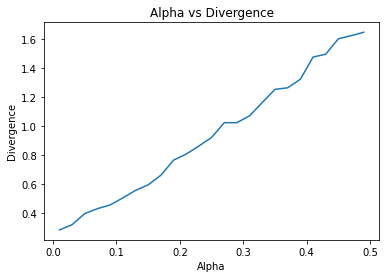

In [49]:
fig_1 = plt.figure('Alpha vs Divergence')
ax = fig_1.add_subplot(1,1,1)
ax.plot(results_alpha['alpha'], results_alpha['divergence'])
ax.set_title('Alpha vs Divergence')
ax.set_xlabel('Alpha')
ax.set_ylabel('Divergence')

Text(0, 0.5, 'Divergence')

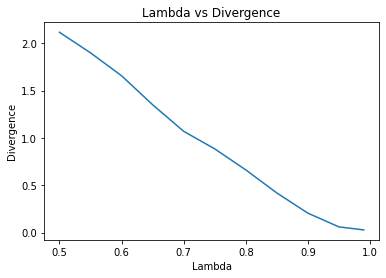

In [50]:
fig_2 = plt.figure('Lambda vs Divergence')
ax = fig_2.add_subplot(1,1,1)
ax.plot(results_lambda['lambda'], results_lambda['divergence'])
ax.set_title('Lambda vs Divergence')
ax.set_xlabel('Lambda')
ax.set_ylabel('Divergence')

In [51]:
start = time.time()
caliberated_recommendation_hotels = recommendation_caliberated(hotels, hotels_visited_weights, 20, lmbda=0.99, alpha=0.01)
elapsed = time.time() - start
print('Time taken to run', elapsed)

Time taken to run 238.3931920528412


In [52]:
caliberated_recommendation_hotels

[hotel122734,
 hotel177679,
 hotel56085,
 hotel119583,
 hotel3671,
 hotel93269,
 hotel26461,
 hotel161750,
 hotel128880,
 hotel36,
 hotel101237,
 hotel26177,
 hotel141310,
 hotel2,
 hotel133699,
 hotel14697,
 hotel123053,
 hotel1099,
 hotel14,
 hotel42924]

In [53]:
caliberated_recommendation_hotels_distribution = category_weights(caliberated_recommendation_hotels)
caliberated_recommendation_hotels_divergence = kl_divergence(hotels_visited_weights, caliberated_recommendation_hotels_distribution)
reco_kl_div = kl_divergence(hotels_visited_weights, hotel_recommendations_weights)

In [54]:
caliberated_recommendation_hotels_distribution

{'Restaurants': 0.16,
 ' American (New)': 0.035,
 ' Event Planning & Services': 0.027,
 ' Hotels': 0.075,
 ' Hotels & Travel': 0.075,
 ' METADATA': 0.219,
 'Event Planning & Services': 0.067,
 ' Caterers': 0.031,
 ' Restaurants': 0.038,
 ' Food Stands': 0.025,
 ' Mexican': 0.077,
 'Nightlife': 0.038,
 ' Bars': 0.038,
 ' Pizza': 0.068,
 ' Asian Fusion': 0.027}

In [58]:
print(f'The best value of kl-divergence can be obtained by the lowest value of alpha ({0.01}) and the highest value of lambda ({0.99}) and the value is {caliberated_recommendation_hotels_divergence}')

The best value of kl-divergence can be obtained by the lowest value of alpha (0.01) and the highest value of lambda (0.99) and the value is 0.008527384953442843
